# Pneumonia Diagnosis from chest X-ray

CNN classiffication with Keras.  
Diagnose pneumonia from chest x-ray

## Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Dropout

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.metrics import roc_curve, auc, confusion_matrix

## Create Image Data Generator from directory

In [4]:
# Data path
# replace data path with inpu from yml file!
data_path = r"C:\Users\leoni\PycharmProjects\Data"
PATH = os.path.join(data_path, "chest_xray")
print(os.listdir(PATH))

['test', 'train', 'val']


In [5]:
# train, validate, test dirs
train_dir = os.path.join(PATH, "train")
val_dir = os.path.join(PATH, "val")
test_dir = os.path.join(PATH, "test")

for d in train_dir, test_dir, val_dir:
    print(os.listdir(d))

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [6]:
# train
pneum_train_dir = os.path.join(train_dir, 'PNEUMONIA')
norm_train_dir = os.path.join(train_dir, 'NORMAL')

#val (move data into train dir and use validation splits)
pneum_val_dir = os.path.join(val_dir, 'PNEUMONIA')
norm_val_dir = os.path.join(val_dir, 'NORMAL')

# test
pneum_test_dir = os.path.join(test_dir, 'PNEUMONIA')
norm_test_dir = os.path.join(test_dir, 'NORMAL')

In [7]:
data_dict = {'pneum_train': len(os.listdir(pneum_train_dir)),
             'norm_train': len(os.listdir(norm_train_dir)),
             'pneum_val': len(os.listdir(pneum_val_dir)),
             'norm_val': len(os.listdir(norm_val_dir)),
             'pneum_test': len(os.listdir(pneum_test_dir)),
             'norm_test': len(os.listdir(norm_test_dir))
            }

print(data_dict)

{'pneum_train': 3875, 'norm_train': 1341, 'pneum_val': 8, 'norm_val': 8, 'pneum_test': 390, 'norm_test': 234}


In [8]:
params = {'batch_size': 256,
          'epochs': 45,
          'img_h': 256,
          'img_w': 256
         }

In [9]:
train_image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1) # Generator for our training data

In [10]:
print("class is %s" % train_image_generator.__class__)
print("parent class is %s" % train_image_generator.__class__.__base__)

class is <class 'tensorflow.python.keras.preprocessing.image.ImageDataGenerator'>
parent class is <class 'keras_preprocessing.image.image_data_generator.ImageDataGenerator'>


In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=params['batch_size'],
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(params['img_h'], params['img_w']),
                                                          color_mode='grayscale',
                                                          class_mode='binary',
                                                          subset='training')

val_data_gen = train_image_generator.flow_from_directory(batch_size=params['batch_size'],
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(params['img_h'], params['img_w']),
                                                          color_mode='grayscale',
                                                          class_mode='binary',
                                                          subset='validation')

Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


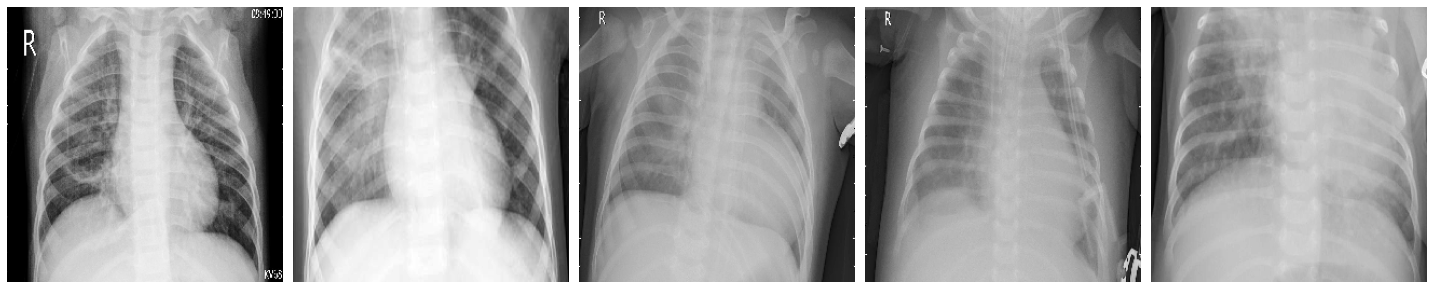

In [12]:
sample_training_images, _ = next(train_data_gen)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
# from https://www.tensorflow.org/tutorials/images/classification
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        # show grayscale image
        ax.imshow(img[:,:,0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig(r"images/xray_sample.png", format="png")
plotImages(sample_training_images[:5])

## Simple CNN (with dropout)

In [54]:
# Architecture
# Should we add the final activation or not? # Activation('sigmoid')
# cnn_1 = tf.keras.models.load_model('cnn_1.h5')
cnn_1 = Sequential([Conv2D(filters=16, kernel_size=4, strides=(1, 1), padding='same', activation='relu',
                          input_shape=(params['img_h'], params['img_w'], 1)),
                    MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
                    Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
                    MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
                    Conv2D(filters=64, kernel_size=2, strides=(1, 1), padding='same', activation='relu'),
                    MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='valid'),
                    Dropout(rate=0.2),
                    Flatten(),
                    Dense(units=512, activation='relu'),
                    Dropout(rate=0.3),
                    Dense(units=1),
                   ])

In [55]:
#cnn_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# if sigmoind activation is used in the model
cnn_1.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

print(cnn_1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 16)      272       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 64)          32832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 64)         

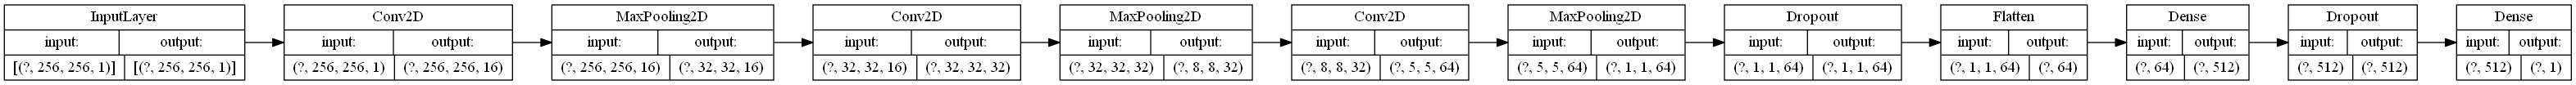

In [56]:
# Plot model
tf.keras.utils.plot_model(cnn_1, to_file=r"images/cnn_dropout.png", rankdir='LR', show_layer_names=False, show_shapes=True)

In [57]:
history = cnn_1.fit_generator(train_data_gen,
                              steps_per_epoch=len(train_data_gen),
                              epochs=params['epochs'],
                              validation_data=val_data_gen,
                              validation_steps=len(val_data_gen)
                             )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 3 steps
Epoch 1/45
 1/19 [>.............................] - ETA: 1:24

InvalidArgumentError:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential_2/dense_5/BiasAdd:0) = ] [[0.0374327376][0.0469167903][0.0317072943]...] [y (metrics/auc_1/Cast_1/x:0) = ] [0]
	 [[{{node metrics/auc_1/assert_greater_equal/Assert/AssertGuard/else/_1/Assert}}]] [Op:__inference_distributed_function_6135]

Function call stack:
distributed_function


In [13]:
cnn_1.save('cnn_1.h5')

NameError: name 'cnn_1' is not defined

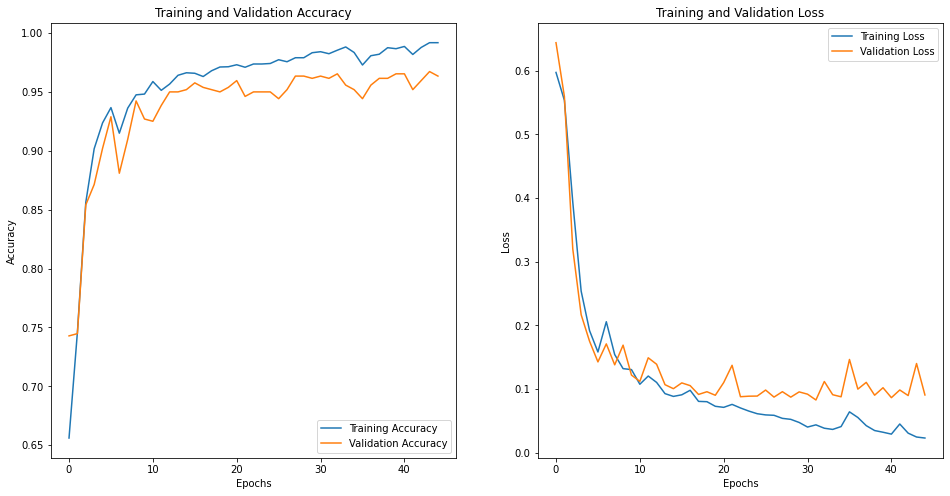

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(params['epochs'])

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
fig.savefig(r"images/Epochs_acc_and_loss.png", format="png")

In [14]:
cnn_1 = tf.keras.models.load_model('cnn_1.h5')

In [18]:
# Quickfix for the the Keras shuffle issue
val_data_gen.shuffle = False
val_data_gen.index_array = None

train_data_gen.shuffle = False
train_data_gen.index_array = None

In [19]:
# Sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [20]:
# Make sure normal is 0 and Pneumonia is 1
val_data_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Performance on Training Set

In [37]:
# Create arrays for y, y_hat and likelihoods
val_pred_probs = sigmoid(cnn_1.predict_generator(val_data_gen))
val_pred = (val_pred_probs > 0.5) * 1
val_actual = val_data_gen.classes.reshape(-1,1)

In [38]:
# Create arrays for y, y_hat and likelihoods
train_pred_probs = sigmoid(cnn_1.predict_generator(train_data_gen))
train_pred = (train_pred_probs > 0.5) * 1
train_actual = train_data_gen.classes.reshape(-1,1)

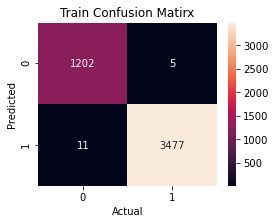

In [39]:
# Confusion matrix
cf = confusion_matrix(train_actual, train_pred)
fig = plt.figure(figsize = (4,3))
ax = fig.gca()
sn.heatmap(cf, annot=True,fmt='g')
plt.title('Train Confusion Matirx')
plt.ylabel('Predicted')
plt.xlabel('Actual')
fig.savefig(r"images/Train_ConfusionMatrix.png", format="png")

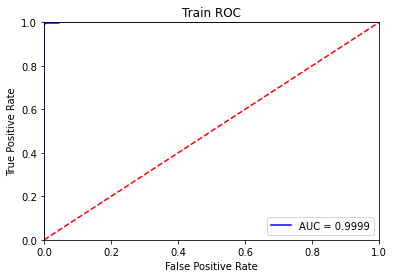

In [40]:
# ROC curve
fpr, tpr, _ = roc_curve(train_actual, train_pred_probs)
cnn_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % cnn_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Train ROC')
plt.show()
fig.savefig(r"images/Training_ROC_curve.png", format="png")

## Perfromance on Validation set

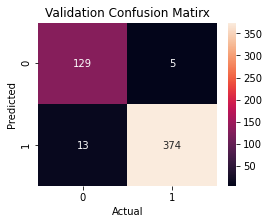

In [47]:
# Confusion matrix
cf = confusion_matrix(val_actual, val_pred)
fig = plt.figure(figsize = (4,3))
ax = fig.gca()
sn.heatmap(cf, annot=True,fmt='g')
plt.title('Validation Confusion Matirx')
plt.ylabel('Predicted')
plt.xlabel('Actual')
fig.savefig(r"images/Val_ConfusionMatrix.png", format="png")

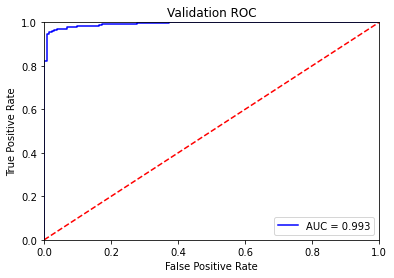

In [42]:
# ROC curve
fpr, tpr, _ = roc_curve(val_actual, val_pred_probs)
cnn_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % cnn_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Validation ROC')
plt.show()
fig.savefig(r"images/Val_ROC_curve.png", format="png")

## Performance on Test set

In [43]:
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data
test_data_gen = test_image_generator.flow_from_directory(batch_size=params['batch_size'],
                                                          directory=test_dir,
                                                          shuffle=False,
                                                          target_size=(params['img_h'], params['img_w']),
                                                          color_mode='grayscale',
                                                          class_mode='binary')

Found 624 images belonging to 2 classes.


In [44]:
# Create arrays for y, y_hat and likelihoods
test_pred_probs = sigmoid(cnn_1.predict_generator(test_data_gen))
test_pred = (test_pred_probs > 0.5) * 1
test_actual = test_data_gen.classes.reshape(-1,1)

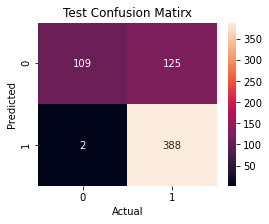

In [45]:
# Confusion matrix
cf = confusion_matrix(test_actual, test_pred)
fig = plt.figure(figsize = (4,3))
ax = fig.gca()
sn.heatmap(cf, annot=True,fmt='g')
plt.title('Test Confusion Matirx')
plt.ylabel('Predicted')
plt.xlabel('Actual')
fig.savefig(r"images/Test_ConfusionMatrix.png", format="png")

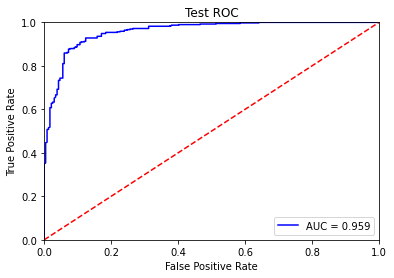

In [46]:
# ROC curve
fpr, tpr, _ = roc_curve(test_actual, test_pred_probs)
cnn_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % cnn_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Test ROC')
plt.show()
fig.savefig(r"images/Test_ROC_curve.png", format="png")